<h1 style="color:#ff5500; font-family:Play; font-size:3em; margin:auto 32px;align:center">Part V - Model Selection</h1>

---

This document is a part of the FACEIT Predictor Data Science Workflow.

In this notebook the Machine Learning Model is selected and its hyperparameters are tuned. Feature selection is also considered.

# Imports


In [1]:
# Measure code execution time
from time import time

# Manage warnings
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# regex
import re

from datetime import datetime

# Model Storage
import joblib

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import StandardScaler

# Model selection and hyperparameter tuning
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV

# Feature selection
from sklearn.feature_selection import RFECV

# Classifiers
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from xgboost import XGBClassifier

# Stacking Classifier
from sklearn.ensemble import StackingClassifier

# Neural network libraries
import tensorflow as tf

# Classifier metrics
from sklearn.metrics import RocCurveDisplay, classification_report, roc_auc_score

# enable imports from parent directory
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# import local modules
from src.utils.loaders import read_data
from src.utils.dirs import MODEL_DIR
from src.utils.visualization import set_visualization_defaults, comp_featured_based_on_winner
from src.models.evaluation import print_metrics, print_metrics_nn, nn_compare_train_val
from src.models.hyperparameter import tune_hypparams, MODELS_PARAMS

from IPython import get_ipython

ipython = get_ipython()

# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
   %load_ext autoreload

# autoreload python modules
%autoreload 2

In [2]:
warnings.filterwarnings("ignore")

In [3]:
set_visualization_defaults()

In [4]:
SEED = 15

# Load Processed Data

In [5]:
data = read_data("processed")

In [6]:
X = data.drop(columns=["winner", "_id"])
y = data["winner"]

Scaling data is crucial for performance of some algorithms.

**TODO: there are several scalers available. Which one should be used?**

In [7]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

Split 70% of the data into the train dataset and the remaining 30% into the test dataset.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [9]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (48241, 47)
X_test shape: (20676, 47)


# Baseline Model

In [10]:
rf = RandomForestClassifier(random_state=SEED)

In [11]:
rf.fit(X_train, y_train);

## Evaluation Fundamentals

Too evaluate a classification model the five most common metrics are:

* Accuracy
* Precision
* Recall
* F1-Score
* AUC (Area under the ROC curve)

**TODO: talk about the most important measures and how they will be presented**

,0,1,macro avg,weighted avg
precision,0.602503,0.607463,0.604983,0.604969
recall,0.629736,0.579685,0.604711,0.604856
f1-score,0.615819,0.593249,0.604534,0.604599
support,10398.000000,10278.000000,20676.000000,20676.000000


Train Accuracy: 1.0000		Test Accuracy: 0.6049


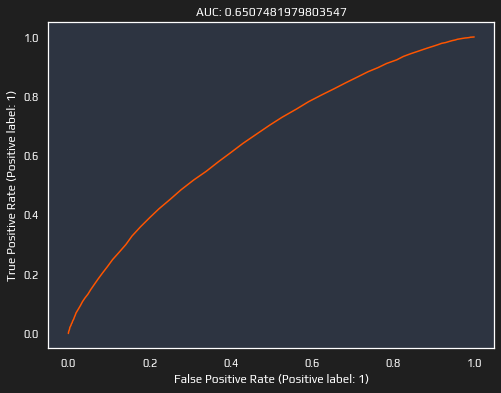

In [12]:
print_metrics(rf, X_train, y_train, X_test, y_test)

In [13]:
feature_importances_df = pd.DataFrame({"features":X_train.columns, "importances":rf.feature_importances_})
feature_importances_df.sort_values(by="importances", ascending=False).head(20)

,features,importances
3,dif_mean_elo,0.045815
29,dif_mean_weighted_kd_by_elo_prev,0.037468
31,dif_mean_rating_prev,0.028639
15,dif_mean_kd_on_map,0.028203
13,dif_mean_matches_on_map,0.028156
18,dif_mean_matches_map_preference,0.027384
28,dif_mean_kd_prev,0.027312
4,dif_stddev_elo,0.027251
9,dif_mean_winrate,0.026969
38,dif_mean_dif_elo_prev,0.026955


# Traditional Classifiers (Scikit-learn)

In [14]:
clfs = {}
clfs["Linear Disc. Analysis"] = LinearDiscriminantAnalysis()
clfs["AdaBoost"] = AdaBoostClassifier(random_state=SEED)
clfs["Bagging"] = BaggingClassifier(random_state=SEED)
clfs["Extra Trees Ensemble"] = ExtraTreesClassifier(random_state=SEED)
clfs["Gradient Boosting"] = GradientBoostingClassifier(random_state=SEED)
clfs["Random Forest"] = RandomForestClassifier(random_state=SEED)
clfs["Ridge"] = RidgeClassifier(random_state=SEED)
clfs["Logistic Regression"] = LogisticRegression(random_state=SEED)
clfs["BernoulliNB"] = BernoulliNB()
clfs["Multi Layer Perceptron"] = MLPClassifier(random_state=SEED)
clfs["Linear SVC"] = LinearSVC(random_state=SEED)
clfs["Decision Tree"] = DecisionTreeClassifier(random_state=SEED)
clfs["Extra Tree"] = ExtraTreeClassifier(random_state=SEED)
clfs["XGB"] = XGBClassifier(random_state=SEED)


# Create dict for classifiers with feature_importances_ attribute
has_feature_importances = {
    "AdaBoost",
    "Extra Trees Ensemble",
    "Gradient Boosting",
    "Random Forest",
    "Decision Tree",
    "Extra Tree",
    "XGB",
}

In [15]:
scoring_metrics = ('accuracy', 'roc_auc')
cv_folds = 5

In [ ]:
clfs_df, fts_imp_df = [], []

for name, clf in clfs.items():
    print("Fitting", name)

    index = pd.MultiIndex.from_product([[name], range(cv_folds)], names=["classifier", "fold_number"])
    output = cross_validate(clf, X_train, y_train, cv=cv_folds, scoring=scoring_metrics, return_train_score=True, return_estimator=True)

    clfs_df.append(pd.DataFrame(output, index=index))

    if name in has_feature_importances:
        fts_imp_df.append(pd.DataFrame([e.feature_importances_ for e in output["estimator"]], index=index, columns=X_train.columns))


clfs_df = pd.concat(clfs_df)
fts_imp_df = pd.concat(fts_imp_df)

In [ ]:
ordered_clfs_df = clfs_df.groupby(by="classifier").median().sort_values(by="test_accuracy", ascending=False)
ordered_clfs_df

In [ ]:
# 'Ignore' fold number index
classifiers_indexes = clfs_df.index.get_level_values(level=0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), sharey=True)
styling_props = {"whiskerprops":{"color":"gray"}, "capprops":{"color":"gray"}, "flierprops":{"markerfacecolor":"gray"}}

sns.boxplot(x=clfs_df.test_accuracy, y=classifiers_indexes, order=ordered_clfs_df.index, ax=ax1, palette="gist_heat", **styling_props)
sns.boxplot(x=clfs_df.test_roc_auc, y=classifiers_indexes, order=ordered_clfs_df.index, ax=ax2, palette="gist_heat", **styling_props)
plt.tight_layout()

In [ ]:
ordered_fts_imp_df = fts_imp_df.median().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(12,16))
ax = sns.boxplot(
    data=fts_imp_df.melt(),
    y="variable",
    x="value",
    order=ordered_fts_imp_df.index,
    palette="gist_heat",
    **styling_props)
    
ax.set_ylabel("Feature Name")
ax.set_xlabel("Feature Importance")
plt.tight_layout()

Write about most promising algorithms based on the results and take into account the algorithms that usually yield better results (such as in Kaggle competitions).

Get Feature importance for the several tree-based algorithms.

## Inital Hyperparameter Tuning

Perform simple hyperparameter tuning on a small range of parameters of the best or most promising algorithms before going into feature selection.

There are some highly regarded algorithms such as XGBoost that currently have a subpar performance, probably due to inadequate hyperparameters. So, using the *raw* and *untuned* version of XGBoost during Feature Selection will propagate such errors and lead to an non-optimal solution.

In [ ]:
xgb_params = {
    "learning_rate": [0.01, 0.05],
    "n_estimators":[50, 100],
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

In [ ]:
xgb = XGBClassifier(random_state=SEED)
gs = GridSearchCV(estimator=xgb, param_grid = xgb_params, cv=cv_folds, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1, return_train_score=True, verbose=2)

gs.fit(X_train, y_train);

In [ ]:
print("Best AUC:", gs.best_score_)
print("Best XGB params:", gs.best_params_)
best_xgb = gs.best_estimator_

## Feature Selection

Recursive feature elimination with cross-validation to select the number of features.

In [ ]:
feature_selector = RFECV(best_xgb, cv=cv_folds, step=1, scoring="roc_auc")
feature_selector.fit(X_train, y_train);

In [ ]:
# list of tuples (n_features, auc_test_score) starting at n_features=1 until 47
n_features_vs_auc = enumerate(feature_selector.cv_results_["mean_test_score"], 1)
n_features_vs_auc_df = pd.DataFrame(n_features_vs_auc, columns=["n_features", "AUC"])

In [ ]:
n_features_opt, auc_opt = n_features_vs_auc_df.sort_values(by="AUC").iloc[-1]
print(f"Max AUC {auc_opt:.4f} for {n_features_opt:.0f} features")

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=n_features_vs_auc_df, x="n_features", y="AUC", marker="o")
ax.set_title("Number of Features vs Test AUC value")
plt.tight_layout()

In [ ]:
n_features_in_ = feature_selector.n_features_in_
n_features = feature_selector.n_features_

# Get selected features
selected_features = feature_selector.feature_names_in_[feature_selector.support_]

nl = '\n'
print(f'From {n_features_in_} features only {n_features} were selected:{nl}{nl.join(selected_features)}')

In [ ]:
X_train_ft_sel = X_train[selected_features]
X_test_ft_sel = X_test[selected_features]

## Extensive Hyperparameter Tuning

Selected algorithms to perform hyperparameter tuning:

* Linear SVC
* Ridge
* Linear Discriminant Analysis
* Logistic Regression
* Gradient Boosting
* AdaBoost
* Random Forest
* XGB

In [16]:
selected_clfs = {}
selected_clfs["Linear SVC"] = LinearSVC(random_state=SEED)
selected_clfs["Ridge"] = RidgeClassifier(random_state=SEED)
selected_clfs["Linear Disc. Analysis"] = LinearDiscriminantAnalysis()
selected_clfs["Logistic Regression"] = LogisticRegression(random_state=SEED)
selected_clfs["Gradient Boosting"] = GradientBoostingClassifier(random_state=SEED)
selected_clfs["AdaBoost"] = AdaBoostClassifier(random_state=SEED)
selected_clfs["Random Forest"] = RandomForestClassifier(random_state=SEED)
selected_clfs["XGB"] = XGBClassifier(random_state=SEED)

In [17]:
hyp_searches = {}

for name, clf in selected_clfs.items():
    print("Hyperparameter tuning of", name)
    hyp_search = tune_hypparams(clf, MODELS_PARAMS[name], X_train, y_train)
    hyp_searches[name] = hyp_search

Hyperparameter tuning of Linear SVC
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Hyperparameter tuning of Ridge
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Hyperparameter tuning of Linear Disc. Analysis
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Hyperparameter tuning of Logistic Regression
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Hyperparameter tuning of Gradient Boosting
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Hyperparameter tuning of AdaBoost
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Hyperparameter tuning of Random Forest
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Hyperparameter tuning of XGB
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [18]:
clfs_df, fts_imp_df = [], []

for name, gs in hyp_searches.items():
    print("Fitting", name)
    best_estimator = gs.best_estimator_
    
    # get estimator class name and remove parentheses (From LinearSVC() to LinearSVC)
    estimator_name = re.sub(r'\([^)]*\)', '', str(best_estimator.__class__()))

    current_date_string = datetime.utcnow().strftime("%Y_%m_%d_%H_%M_%S")
    model_folder_path = MODEL_DIR / f'model_{estimator_name}_{current_date_string}'

    # create models folder
    os.mkdir(model_folder_path)

    # save models
    joblib.dump(best_estimator, f'{str(model_folder_path)}/model.joblib')

    index = pd.MultiIndex.from_product([[name], range(cv_folds)], names=["classifier", "fold_number"])
    output = cross_validate(best_estimator, X_train, y_train, cv=cv_folds, scoring=scoring_metrics, return_train_score=True, return_estimator=True)

    clfs_df.append(pd.DataFrame(output, index=index))

    if name in has_feature_importances:
        fts_imp_df.append(pd.DataFrame([e.feature_importances_ for e in output["estimator"]], index=index, columns=X_train.columns))


clfs_df = pd.concat(clfs_df)
fts_imp_df = pd.concat(fts_imp_df)

Fitting Linear SVC
Fitting Ridge
Fitting Linear Disc. Analysis
Fitting Logistic Regression
Fitting Gradient Boosting
Fitting AdaBoost
Fitting Random Forest
Fitting XGB


In [19]:
ordered_clfs_df = clfs_df.groupby(by="classifier").median().sort_values(by="test_accuracy", ascending=False)
ordered_clfs_df

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
classifier,,,,,,
Linear Disc. Analysis,0.188673,0.010005,0.617537,0.617184,0.666221,0.666964
Linear SVC,13.645145,0.011472,0.616915,0.616848,0.666948,0.667455
Logistic Regression,1.056756,0.010893,0.616294,0.617755,0.667205,0.667569
Ridge,0.077891,0.011004,0.615568,0.616718,0.666696,0.667275
AdaBoost,128.157656,4.132959,0.612977,0.621201,0.663941,0.674319
XGB,30.397032,0.274770,0.612355,0.675952,0.664312,0.748435
Gradient Boosting,34.711075,0.077819,0.611629,0.628508,0.664587,0.682384
Random Forest,127.726998,1.834215,0.605100,0.608064,0.649863,0.657796


In [20]:
# 'Ignore' fold number index
classifiers_indexes = clfs_df.index.get_level_values(level=0)

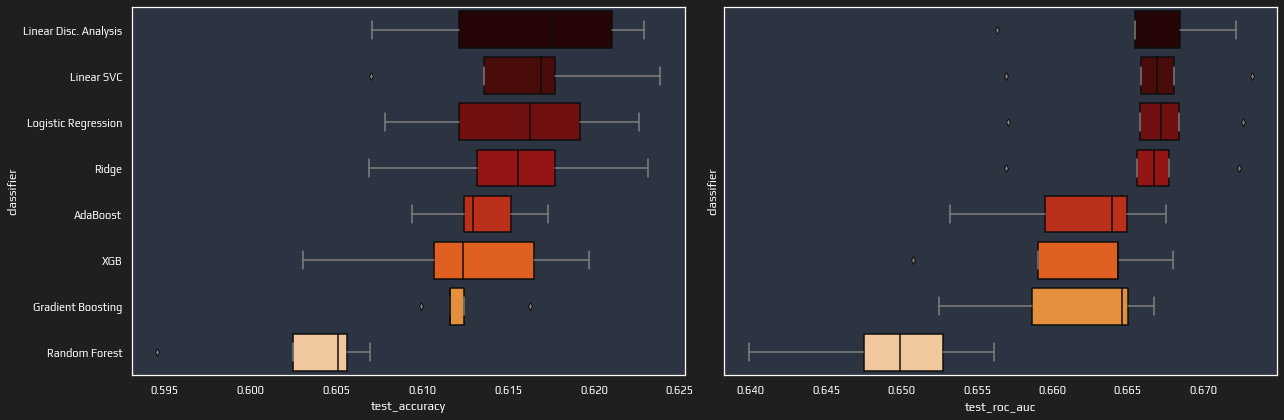

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), sharey=True)
styling_props = {"whiskerprops":{"color":"gray"}, "capprops":{"color":"gray"}, "flierprops":{"markerfacecolor":"gray"}}

sns.boxplot(x=clfs_df.test_accuracy, y=classifiers_indexes, order=ordered_clfs_df.index, ax=ax1, palette="gist_heat", **styling_props)
sns.boxplot(x=clfs_df.test_roc_auc, y=classifiers_indexes, order=ordered_clfs_df.index, ax=ax2, palette="gist_heat", **styling_props)
plt.tight_layout()

# Neural Networks

## Overfit Model

In [26]:
# Initializing Neural Network
nn = tf.keras.Sequential()

In [27]:
# Adding input layer
nn.add(tf.keras.layers.Dense(32, input_shape=(len(X_train.columns),), activation="relu"))

# Adding hidden layers
nn.add(tf.keras.layers.Dense(16, activation="relu"))
nn.add(tf.keras.layers.Dense(8, activation="relu"))

# Adding output layer
nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [28]:
print(nn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                1536      
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
# compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
history = nn.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.15, verbose=1)

Epoch 1/20
411/411 [==============================] - 1s 2ms/step - loss: 0.6655 - accuracy: 0.5907 - val_loss: 0.6534 - val_accuracy: 0.6012
Epoch 2/20
411/411 [==============================] - 1s 1ms/step - loss: 0.6513 - accuracy: 0.6110 - val_loss: 0.6498 - val_accuracy: 0.6036
Epoch 3/20
411/411 [==============================] - 0s 806us/step - loss: 0.6474 - accuracy: 0.6156 - val_loss: 0.6483 - val_accuracy: 0.6074
Epoch 4/20
411/411 [==============================] - 0s 1ms/step - loss: 0.6453 - accuracy: 0.6186 - val_loss: 0.6487 - val_accuracy: 0.6087
Epoch 5/20
411/411 [==============================] - 0s 980us/step - loss: 0.6437 - accuracy: 0.6196 - val_loss: 0.6480 - val_accuracy: 0.6072
Epoch 6/20
411/411 [==============================] - 0s 1ms/step - loss: 0.6425 - accuracy: 0.6217 - val_loss: 0.6490 - val_accuracy: 0.6065
Epoch 7/20
411/411 [==============================] - 0s 1ms/step - loss: 0.6416 - accuracy: 0.6225 - val_loss: 0.6503 - val_accuracy: 0.6051
Ep

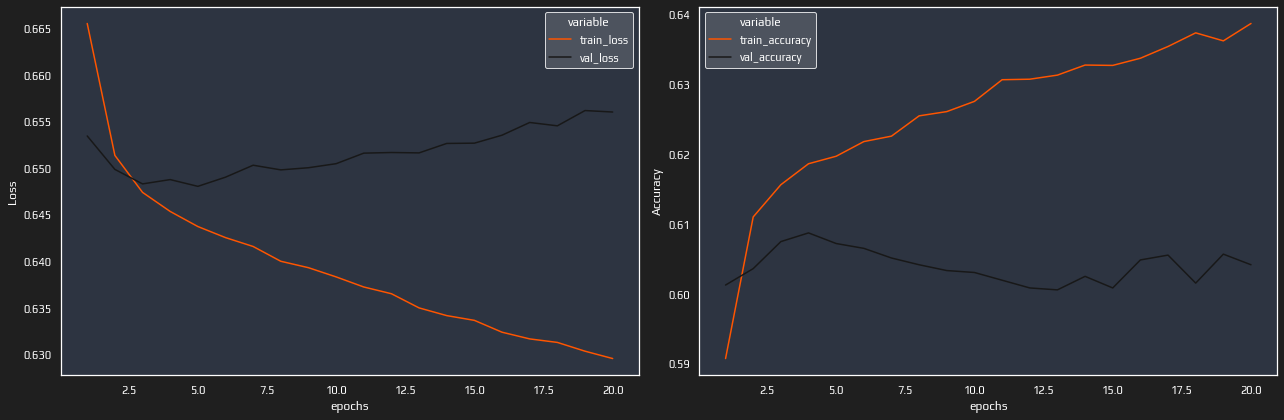

In [31]:
nn_compare_train_val(history)

## Non-Overfit Model

In [51]:
# Initializing Neural Network
nn = tf.keras.Sequential()

In [52]:
# Adding input layer
nn.add(tf.keras.layers.Dense(32, input_shape=(len(X_train.columns),), activation="relu"))

# Adding hidden layers
nn.add(tf.keras.layers.Dropout(rate=0.5))
nn.add(tf.keras.layers.Dense(16, activation="relu"))
nn.add(tf.keras.layers.Dropout(rate=0.5))
nn.add(tf.keras.layers.Dense(8, activation="relu"))

# Adding output layer
nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [53]:
# compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
history = nn.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.15, verbose=1)

Epoch 1/40
411/411 [==============================] - 1s 2ms/step - loss: 0.7041 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.5104
Epoch 2/40
411/411 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5158 - val_loss: 0.6911 - val_accuracy: 0.5432
Epoch 3/40
411/411 [==============================] - 1s 2ms/step - loss: 0.6881 - accuracy: 0.5408 - val_loss: 0.6829 - val_accuracy: 0.5687
Epoch 4/40
411/411 [==============================] - 1s 2ms/step - loss: 0.6819 - accuracy: 0.5654 - val_loss: 0.6731 - val_accuracy: 0.5871
Epoch 5/40
411/411 [==============================] - 1s 2ms/step - loss: 0.6784 - accuracy: 0.5763 - val_loss: 0.6750 - val_accuracy: 0.5842
Epoch 6/40
411/411 [==============================] - 1s 2ms/step - loss: 0.6747 - accuracy: 0.5848 - val_loss: 0.6734 - val_accuracy: 0.5902
Epoch 7/40
411/411 [==============================] - 1s 2ms/step - loss: 0.6705 - accuracy: 0.5915 - val_loss: 0.6645 - val_accuracy: 0.6047
Epoch 

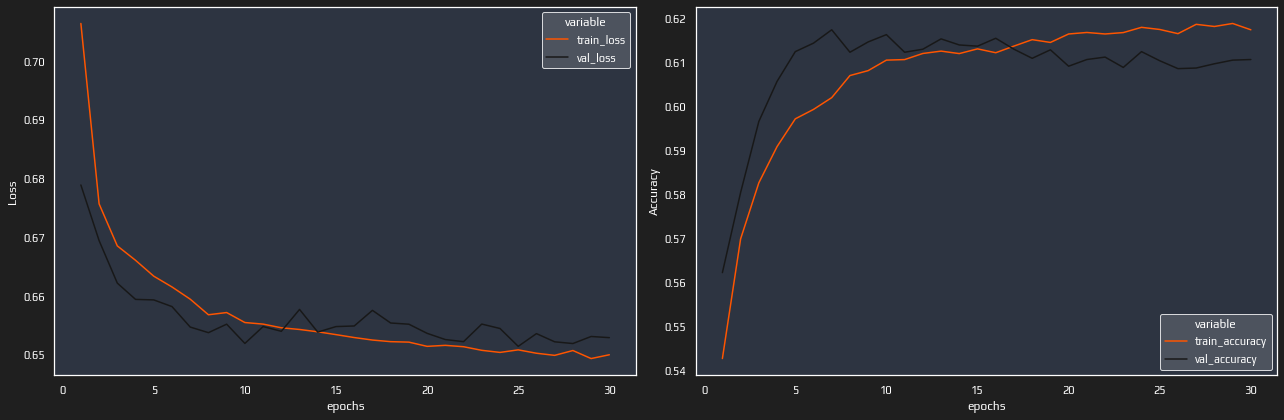

In [46]:
nn_compare_train_val(history)

In [221]:
# Evaluate the model
print_metrics_nn(nn, X_train, y_train, X_test, y_test)

,0,1,macro avg,weighted avg
precision,0.622873,0.608024,0.615449,0.615492
recall,0.595018,0.635532,0.615275,0.615158
f1-score,0.608627,0.621474,0.615050,0.615013
support,10398.000000,10278.000000,20676.000000,20676.000000


Train Accuracy: 0.6223		Test Accuracy: 0.6152
AUC Score: 0.6653010063268638


# Stacking Classifier

In [27]:
estimators = list(zip(hyp_searches.keys(), [h.best_estimator_ for h in hyp_searches.values()]))

In [29]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv_folds)

In [30]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('Linear SVC', LinearSVC(C=1, random_state=15)),
                               ('Ridge',
                                RidgeClassifier(alpha=0.1, random_state=15)),
                               ('Linear Disc. Analysis',
                                LinearDiscriminantAnalysis(shrinkage=0.02,
                                                           solver='lsqr')),
                               ('Logistic Regression',
                                LogisticRegression(C=0.1, random_state=15,
                                                   solver='liblinear')),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(max_...
                                              interaction_constraints='',
                                              learning_rate=0.005,
                                              max_delta_step=0, max_depth=7,
                           

,0,1,macro avg,weighted avg
precision,0.620021,0.618391,0.619206,0.619211
recall,0.627236,0.611111,0.619174,0.619220
f1-score,0.623608,0.614730,0.619169,0.619194
support,10398.000000,10278.000000,20676.000000,20676.000000


Train Accuracy: 0.6283		Test Accuracy: 0.6192


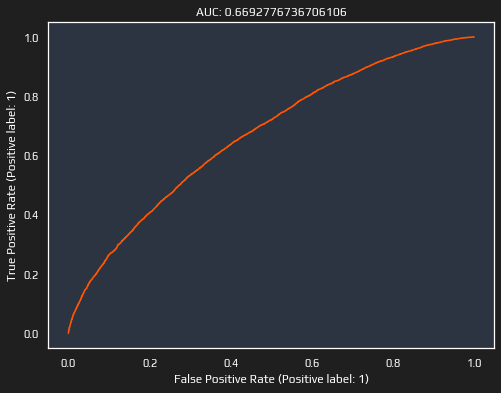

In [31]:
print_metrics(stacking_clf, X_train, y_train, X_test, y_test)

# Store Model

In [213]:
current_date_string = datetime.utcnow().strftime("%Y_%m_%d_%H_%M_%S")
model_folder_path = MODEL_DIR / f'model_{current_date_string}'

# create models folder
os.mkdir(model_folder_path)

In [215]:
# save models
joblib.dump(stacking_clf, f'{str(model_folder_path)}/model.joblib');